In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import yappi

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

BATCH_SIZE = 32

1.7.0


In [2]:
# Utility for loading up the dataset

def load_adult_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
                    'martial_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names,
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['race'].isin(['White', 'Black'])])

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'fnlwgt'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))

    y = y.to_frame()
    for col in X.columns:
        X[col] = X[col].astype('float32')

    for col in y.columns:
        y[col] = y[col].astype('float32')

    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape} samples")
    return X, y

class PandasDataSet(TensorDataset):
    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDataSet, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame('dummy')
        return torch.from_numpy(df.values).float()

In [3]:
# load adult data set
path = 'adult.data'
# path = 'adult.data'
X, y = load_adult_data(path)

n_features = X.shape[1]

# split into train/test set
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)
print(X_train.head())

features X: 30940 samples, 95 attributes
targets y: (30940, 1) samples
        age  education_num  capital_gain  capital_loss  hours_per_week  \
27719  17.0            7.0           0.0           0.0            12.0   
936    47.0           14.0           0.0           0.0            25.0   
3936   46.0           11.0           0.0           0.0            38.0   
8500   45.0           14.0           0.0        1902.0            50.0   
3882   51.0           10.0           0.0           0.0            40.0   

       workclass_Local-gov  workclass_Never-worked  workclass_Private  \
27719                  0.0                     0.0                1.0   
936                    0.0                     0.0                1.0   
3936                   0.0                     0.0                0.0   
8500                   0.0                     0.0                1.0   
3882                   0.0                     0.0                1.0   

       workclass_Self-emp-inc  workclass_Self

In [4]:
# Set up training & testing data
BATCH_SIZE = 100

train_data = PandasDataSet(X_train, y_train)
test_data = PandasDataSet(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print('# training samples:', len(train_data))
print('# testing samples:', len(test_data))
print('# batches:', len(train_loader))

print('# training samples:', len(test_data))
print('# batches:', len(test_loader))

# training samples: 24752
# testing samples: 6188
# batches: 247
# training samples: 6188
# batches: 61


In [5]:
def accuracy(model, test_loader):
    correct = 0

    for examples, labels in test_loader:
        output = model.forward(examples)
        batch_correct = torch.sum(torch.abs(output - labels) < 0.5)
        correct += batch_correct

    acc = float(correct)/len(test_data)
    
    return acc

In [6]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

# Flatten and reconstruct network weights

In [8]:
def flatten(grads):
    shapes = [g.shape for g in grads]
    flats = [x.view(-1) for x in grads]
    lens = [len(f) for f in flats]
    view = torch.cat(flats)
    return view, shapes, lens

def reshape(view, shapes, lens):
    i = 0
    tensors = []
    for s, l in zip(shapes, lens):
        flat = view[i: i + l]
        tensors.append(flat.view(s))
        i += l
    return tensors
    

In [10]:
from autograd_hacks import *

# Calculate DP Noise

In [15]:
def clipped_grad(model, loss, C):
    # do gradient for each element in loss
    first_order_grads = [torch.autograd.grad([l], model.parameters(), retain_graph=True, create_graph=True) for l in loss]
    shapes = []
    lens = []
    views = []
    # flatten views out per sample
    for f in first_order_grads:
        v, shapes, lens = flatten(f)
        views.append(v)
    #views = [torch.cat([x.view(-1) for x in f]) for f in first_order_grads]


    # a norm for every sample
    grad_l2_norms = [torch.norm(v, p = 2) for v in views]
    
    # divisors turned out to be recipricol multiplication
    divisors = [C/norm.item() if norm.item() > C else 1 for norm in grad_l2_norms]
        
    # the part where we clip
    clipped_grads = [v*d for v, d in zip(views, divisors)]
    
    # sum of gradients
    cg_sum = torch.stack(clipped_grads, dim=0).sum(dim=0)
    
    # reshape per model shape
    cgs = reshape(cg_sum, shapes, lens)
    return cgs

In [16]:
def run_experiment(epsilon):
    # reset the model
    torch.manual_seed(1)
    np.random.seed(7)
    model = Classifier(n_features=n_features)
    # reduction = none makes sure that we get per sample loss
    model_criterion = nn.BCELoss(reduction='none')
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 10
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 2
    epsilon_iter = epsilon / iters
    C = 1.5
    
    # plotting criteria
    train_losses = []
    test_accs = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            inp = Variable(x_batch_train, requires_grad=True)
    
            outputs = model.forward(inp)
            loss = model_criterion(outputs, y_batch_train)
            clipper = clipped_grad(model, loss, C)
            # we have to average the losses because they are per sample now
            mean_loss = loss.mean()
            mean_loss.backward()
            train_losses.append(mean_loss) 

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((C**2 * alpha) / (2 * epsilon_iter))

            count = 0
            with torch.no_grad():
                for p in model.parameters():
                    p.grad = clipper[count] + (sigma * torch.randn(1))
                    count += 1

            model_optimizer.step()


        test_accs.append(accuracy(model, test_loader))
        print("Accuracy:", test_accs[-1])
    return accuracy(model, test_loader), (train_losses, test_accs)

In [113]:
### autograd_hacks version


def clipped_autograd(model, C):
    clipped_grads = []
    max_norms = []
    for param in model.parameters():
        t1 = torch.transpose(param.grad1, 0, 1)
        if len(param.grad.shape) == 1:
            d = 1
            t = t1
        else:
            d = (1,2)
            t = torch.transpose(t1, 1, 2)
        norms = param.grad1.data.norm(dim=d)
        torch.equal(norms, param.grad1.norm(dim=d))
        max_norms.append(torch.max(norms))
        c_norms = C / norms 
        
        clips_with_ones = torch.minimum(c_norms, torch.ones(c_norms.shape))
        clipped_grads.append(torch.matmul(t, clips_with_ones))
        
    return clipped_grads, max(max_norms)

def run_experiment_autograd(epsilon, C=1.5):
    # reset the model
    torch.manual_seed(1)
    np.random.seed(7)
    model = Classifier(n_features=n_features)
    # reduction = none makes sure that we get per sample loss
    model_criterion = nn.BCELoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)
    autograd_hacks.add_hooks(model)

    # number of epochs and iterations
    epochs = 10
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 2
    epsilon_iter = epsilon / iters
    
    # plotting criteria
    train_losses = []
    test_accs = []
    max_norms = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            inp = Variable(x_batch_train, requires_grad=True)
            outputs = model.forward(inp)
            loss = model_criterion(outputs, y_batch_train)
            # we have to average the losses because they are per sample now
            loss.backward()
            autograd_hacks.compute_grad1(model)
            clipper, mn = clipped_autograd(model, C)
            max_norms.append(mn)
            autograd_hacks.clear_backprops(model)
            train_losses.append(loss) 

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((C**2 * alpha) / (2 * epsilon_iter))

            count = 0
            with torch.no_grad():
                for p in model.parameters():
                    p.grad = clipper[count] + (sigma * torch.randn(1))
                    count += 1

            model_optimizer.step()


        test_accs.append(accuracy(model, test_loader))
        print("Accuracy:", test_accs[-1])
    return accuracy(model, test_loader), (train_losses, test_accs, max_norms)

In [116]:
exper = run_experiment_autograd(10, C=10000)

Start of epoch 0
Accuracy: 0.5906593406593407
Start of epoch 1
Accuracy: 0.7596961861667744
Start of epoch 2
Accuracy: 0.7569489334195216
Start of epoch 3
Accuracy: 0.7546864899806076
Start of epoch 4
Accuracy: 0.7498383968972204
Start of epoch 5
Accuracy: 0.7558177117000646
Start of epoch 6
Accuracy: 0.7529088558500323
Start of epoch 7
Accuracy: 0.7478991596638656
Start of epoch 8
Accuracy: 0.7672915319974144
Start of epoch 9
Accuracy: 0.7668067226890757


In [115]:
acc, tup = exper
tl, ta, mn = tup
print(max(mn))

tensor(11736.4648)


In [107]:
epsilons = [0.1, 0.5, 1.0, 5.0, 10.0]
#yappi.set_clock_type("cpu")  # Use set_clock_type("wall") for wall time
#yappi.start()
experiment_results = [run_experiment_autograd(epsilon)[0] for epsilon in epsilons]
#yappi.get_func_stats().print_all()
#yappi.get_thread_stats().print_all()

Start of epoch 0


KeyboardInterrupt: 

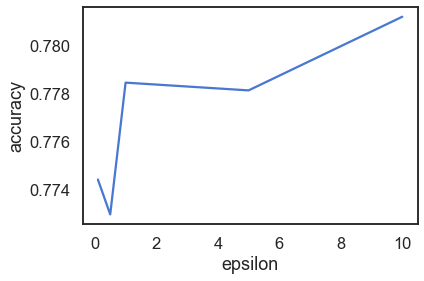

In [72]:
plt.plot(epsilons, experiment_results)
plt.xlabel('epsilon')
plt.ylabel('accuracy');